Use the tweets for the updated vocab, test classifer on humor

In [1]:
!pwd

/home/farzin/haha_2019


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [5]:
PATH = Path('./data/rnn/')

In [6]:
all_texts_df = pd.read_csv('./data/haha_training_2018.csv')

In [7]:
all_texts_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1,0,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,1,1,0,1,1,3.0
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN


### apply pre-rules to text

In [8]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

# def sub_br(t:str) -> str:
#     "Replaces the <br /> by \n"
#     re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
#     return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [9]:
## apply the rules
raw_text = all_texts_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")

for rule in default_rules:
    print(rule)
    raw_text = raw_text.apply(lambda x: rule(str(x)))
    
all_texts_df['new_text'] =  raw_text #tokenizer adds xxbos

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 


<function fixup at 0x7f4e72e250d0>
<function replace_rep at 0x7f4e72e61ea0>
<function replace_wrep at 0x7f4e72e61f28>
<function deal_caps at 0x7f4e72e25048>
<function spec_add_spaces at 0x7f4e72e61268>
<function rm_useless_spaces at 0x7f4e72e61e18>
<function sub_nl at 0x7f4e72e61950>


In [10]:
all_texts_df['new_text'].head()

0    niveles de retraso mental: xxnl xxnl — bajo.xx...
1    —vamos luke desenfunda tu sable , demuestra tu...
2    - ¿te ofrezco algo ? , ¿agua , café , mi coraz...
3                no se porqué me hago la cabeza deooos
4    quisiera saber que hago durante la siesta de l...
Name: new_text, dtype: object

In [11]:
all_texts_df.shape

(16000, 11)

### Clean up the imbalanced data to balance

In [12]:
print('Number of positive samples:', (all_texts_df.is_humor == 1).sum())
print('Number of negative samples:',  (all_texts_df.is_humor == 0).sum())
print('Total samples:', len(all_texts_df))

Number of positive samples: 5865
Number of negative samples: 10135
Total samples: 16000


In [13]:
rnd_seed = 20190313
np.random.seed(rnd_seed)

idx = np.random.permutation(len(all_texts_df))
test_cut = int(0.15 * len(idx))
valid_cut = int(0.15 * len(idx-test_cut))

df_train_all = all_texts_df.iloc[idx[:-(valid_cut+test_cut)],:]
df_valid     = all_texts_df.iloc[idx[-(valid_cut+test_cut):-test_cut],:]
df_test      = all_texts_df.iloc[idx[-test_cut:],:]

In [14]:
print('Test prevalence(n = %d):'%len(df_test),df_test.is_humor.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.is_humor.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.is_humor.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(all_texts_df))
assert len(all_texts_df) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 2400): 0.36833333333333335
Valid prevalence(n = 2400): 0.37583333333333335
Train all prevalence(n = 11200): 0.3641964285714286
all samples (n = 16000)


In [15]:
## oversample the less-frequent occuring cases
# split the training data into positive and negative
rows_pos = df_train_all.is_humor == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
df_train_pos.shape,df_train_neg.shape

((4079, 11), (7121, 11))

In [16]:
df_resample_pos = df_train_pos.sample(n=len(df_train_neg),replace=True,
                                      axis=0,random_state=rnd_seed).reset_index(drop=True)
df_train = pd.concat([df_resample_pos,df_train_neg],axis=0) #randomized again in DataBunch?
print('Train prevalence (n = %d):'%len(df_train), df_train.is_humor.sum()/ len(df_train))

Train prevalence (n = 14242): 0.5


### sp tokenizer from training

In [17]:
model_prefix = './all_tweets_es_0509'

In [18]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
#         itos[line_num] = line.split("\t")[0]
        itos.append(line.split("\t")[0])
        
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
#         return self.tok.EncodeAsIds(t)  ## tokenize + numericalize. We have them broken into two parts,just return tokens
        return self.tok.EncodeAsPieces(t)
        
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
    
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [19]:
itos[-10:]

['→', '😫', '🤨', '😲', '🏟', '📖', '🎸', '🏿', '😮', '🎬']

In [20]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [21]:
data = TextClasDataBunch.from_df(PATH,df_train,df_valid,df_test,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [22]:
data.show_batch(10)  #less xxunk, but still a fair amount...

text,target
▁ xxbos ▁❤ .- ~ * ( ▁? ▁el ▁di vo 00 ▁d 3 ▁tw 1 tter ▁! ▁! ▁! ▁? ▁? ▁~ k 3 ▁di 4 vl 0 zz ▁ki 3 r 3 z ▁k 3 ▁p 4 rt 3 ▁d 3 ▁no 00 ▁n 0 ▁3 nt 13 nd 3 z ▁b 3 the ▁k 0 n ▁ki 3 n ▁t 3 ▁d 3 ▁l 4 ▁g 4,0
"▁ xxbos ▁¡ dame ▁la ▁"" t "" ▁! ▁... ▁¡ t ▁! ▁ xxnl ▁¡ dame ▁la ▁"" e "" ▁! ▁... ▁¡ e ▁! ▁ xxnl ▁¡ dame ▁la ▁"" a "" ▁! ▁... ▁¡ a ▁! ▁ xxnl ▁¡ dame ▁la ▁"" m "" ▁! ▁... ▁¡ m ▁! ▁ xxnl ▁¡ dame ▁la ▁"" o "" ▁! ▁... ▁¡ o ▁! ▁ xxnl ▁¿¡ qué ▁dice",1
▁ xxbos ▁estaban ▁2 ▁perros ▁hablando : ▁ xxnl ▁— wo of ▁wo of . ▁ xxnl ▁— ▁ xxup ▁woo of ▁! ▁ xxnl ▁— ▁ xxup ▁wo of ▁! ▁¡ ▁ xxup ▁wo of ▁! ▁ xxnl ▁— wo of ▁wo of ▁wo of ▁! ▁ xxnl ▁— y ▁ud ▁ xxup ▁como ▁un ▁ xxup ▁tonto ▁ xxup ▁lad r ándole ▁a ▁la ▁ xxup ▁pantalla ▁#,1
▁ xxbos ▁ xxunk 🌹 g . ▁n ▁ros es xxnl ▁ xxunk arc tic ▁mon ke ys xxnl ▁ xxunk the ▁do ors xxnl ▁📻 xxunk radio head xxnl ▁ xxunk to ol xxnl ▁ xxunk muse xxnl ▁ xxunk roll ing ▁s . xxnl ▁🔥 xxunk flam ing ▁lips xxnl ▁👊 👊 f . ▁fighters xxnl ▁ xxunk 💥 xxunk the ▁clash xxnl ▁ xxunk 🔥 ar cade,0
▁ xxbos ▁esperando ▁a ▁que ▁me ▁contestes ▁por ▁whatsapp ▁ xxnl ▁ xxnl ▁| < 😄 xxnl ▁| ▁(( > xxnl ▁| ▁| ▁ xxunk ▁ xxnl ▁ xxnl ▁| < 😔 xxnl ▁| ▁(( > xxnl ▁| ▁| ▁ xxunk ▁ xxnl ▁ xxnl ▁| < 😭 xxnl ▁| ▁(( > xxnl ▁| ▁| ▁ xxunk ▁ xxnl ▁ xxnl ▁| < xxunk xxnl ▁| ▁(( > xxnl ▁|,1
▁ xxbos ▁ xxup ▁adn ▁de ▁ xxup ▁las ▁ xxup ▁mujeres : xxnl ▁ xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡,1
▁ xxbos ▁ xxup ▁adn ▁de ▁ xxup ▁las ▁ xxup ▁mujeres : xxnl ▁ xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡 xxnl ▁😡 ▁😡,1
"▁ xxbos ▁—¿ a ▁qué ▁te ▁dedicas ▁? ▁ xxnl ▁ xxnl ▁— a ▁la ▁tele patía . xxnl ▁ xxnl ▁—¿ hab las ▁por ▁la ▁mente ▁? ▁ xxnl ▁ xxnl ▁— no ▁, ▁vendo ▁televis ores ▁para ▁tías . ▁ xxup ▁tele ▁pa ▁ xxup ▁tía . xxnl ▁ xxnl ▁—¡ ▁ xxup ▁vete ▁a ▁la ▁ xxup ▁mierda ▁! ▁ xxnl ▁ xxnl ▁— ay ▁:'(",1
▁ xxbos ▁¡ ▁ xxup ▁desde ▁el ▁ xxup ▁pasado ▁ xxup ▁jueves ▁ xxup ▁pague ▁la ▁ xxup ▁cajita ▁ xxup ▁clap ▁ xxup ▁que ▁ xxup ▁desde ▁ xxup ▁septiembre ▁no ▁ xxup ▁ven dian ▁en ▁mi ▁ xxup ▁barrio ▁ xxup ▁calle ▁ xxup ▁soledad ▁ xxup ▁sector ▁5 ▁ xxup ▁bocas ▁ xxup ▁cab im ás ▁y ▁ xxup ▁sin ▁ xxup ▁llegar ▁!,0
"▁ xxbos ▁— mamá ▁, ▁¿ puedo ▁salir ▁? ▁— no . ▁—¿ me ▁das ▁un ▁calce tín ▁? ▁— ok ▁, ▁toma . ▁— el ▁ xxup ▁amo ▁le ▁ha ▁ xxup ▁dado ▁a ▁ xxup ▁dob by ▁un ▁ xxup ▁calce tín ... ▁¡ ▁ xxup ▁dob by ▁es ▁ xxup ▁libre ▁! ▁# ▁ xxup ▁jajaja ▁# ▁ xxup ▁hp quo tes ▁# ▁xd",1


### Check `xxunk` fraction on humor data

In [23]:
pct_xxunk = pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]])
pct_xxunk[pct_xxunk>0].shape, pct_xxunk.shape

((476,), (14242,))

In [24]:
498/20704.

0.024053323029366306

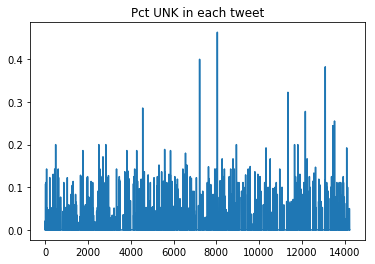

In [25]:
pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]]).plot()
_ = plt.title('Pct UNK in each tweet')

### build and train model

In [26]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 2304

learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
learn.load_encoder('twitter_es_enc_QRNN_0517_labelsmooth')

In [27]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [28]:
from fastai.layers import LabelSmoothingCrossEntropy
learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [29]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


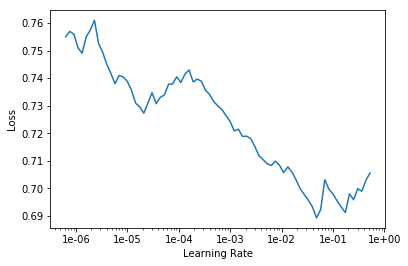

In [30]:
learn.recorder.plot(skip_end=10)

In [31]:

## transform that will drop (replace?) low prob words in each input batch.  
# 1) run words through LM, find prob of next word for each word
# 2) use prob to adjust/drop each word in the batch
# 3) Use a transform/augmentation for each prediction.

### Transform that will change/replace the entire sentence.  En-Fr -> Fr-En to get the same semantics, but new set of words.
## can we do with many words?  Can we couple with single-word drop/replace?
## multiplies the amount of transforms?  Applied after word-level transform?

In [31]:
learn.unfreeze()
## 0.7 drop
learn.fit_one_cycle(20, slice(1e-2/(2.6**4),1e-2), moms=(0.7,0.4), pct_start=0.25, div_factor=8.,
             callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model_Q')])

epoch,train_loss,valid_loss,accuracy,time
0,0.539328,0.458334,0.825833,00:13
1,0.590944,0.432842,0.840833,00:12
2,0.519057,0.440495,0.840000,00:13
3,0.495039,0.418538,0.863333,00:13
4,0.484278,0.414843,0.862500,00:13
5,0.513669,0.406797,0.871250,00:12
6,0.411987,0.417804,0.869167,00:14
7,0.428629,0.426466,0.866250,00:12
8,0.396094,0.416589,0.865833,00:13
9,0.364979,0.448784,0.870000,00:13


Better model found at epoch 0 with accuracy value: 0.8258333206176758.
Better model found at epoch 1 with accuracy value: 0.840833306312561.
Better model found at epoch 3 with accuracy value: 0.8633333444595337.
Better model found at epoch 5 with accuracy value: 0.8712499737739563.
Better model found at epoch 12 with accuracy value: 0.871666669845581.
Better model found at epoch 13 with accuracy value: 0.8729166388511658.


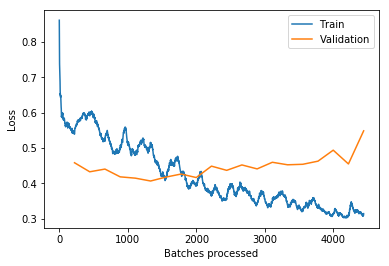

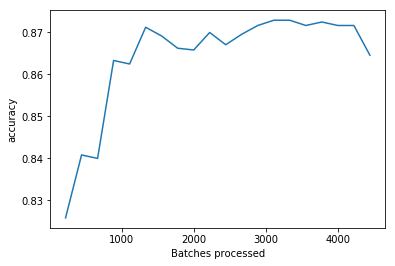

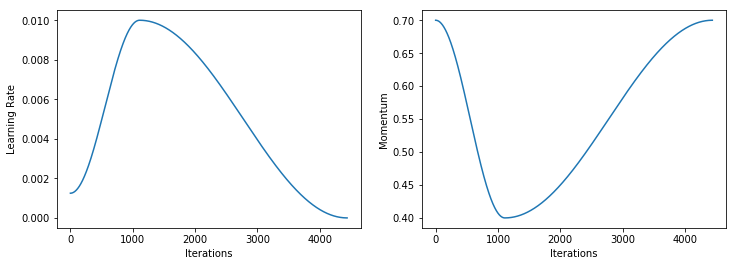

In [32]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.recorder.plot_lr(show_moms=True)

In [33]:
learn.fit(20, slice(1e-2/(2.6**5), 1e-2/8.),
             callbacks=[SaveModelCallback(learn,every='improvement',mode='max',monitor='accuracy',name='best_acc_model_Q')])

epoch,train_loss,valid_loss,accuracy,time
0,0.325791,0.441368,0.872917,00:13
1,0.317832,0.463952,0.873333,00:13
2,0.307571,0.455167,0.871250,00:13
3,0.329909,0.514750,0.869583,00:12
4,0.302498,0.468625,0.872917,00:13
5,0.326468,0.487390,0.872083,00:12
6,0.304142,0.496113,0.872917,00:13
7,0.318486,0.496989,0.866667,00:12
8,0.292429,0.478430,0.872083,00:13
9,0.300715,0.447217,0.875000,00:13


Better model found at epoch 0 with accuracy value: 0.8729166388511658.
Better model found at epoch 1 with accuracy value: 0.8733333349227905.
Better model found at epoch 9 with accuracy value: 0.875.


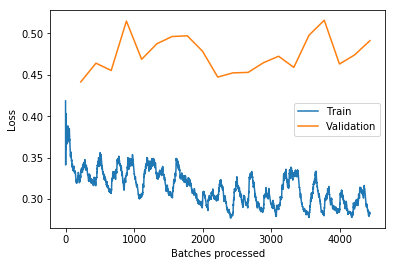

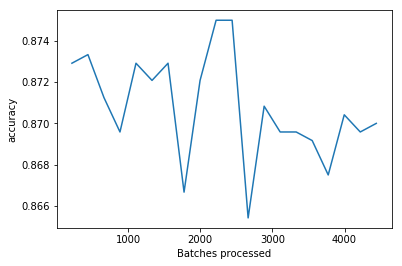

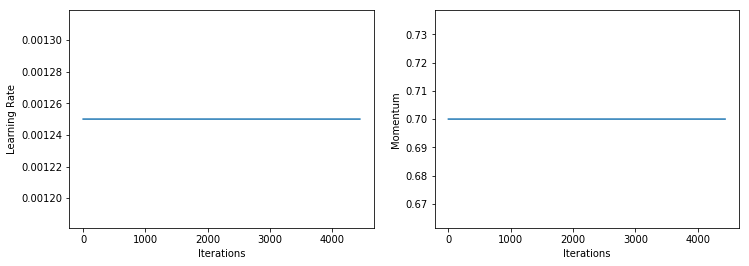

In [34]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.recorder.plot_lr(show_moms=True)

In [35]:
learn.save('2018_example_rnn_trained_unfreezeAll_labelsmoothing_lmAndclas')

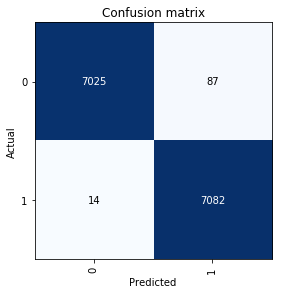

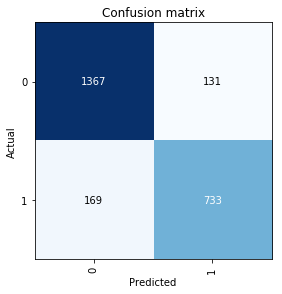

In [36]:
preds_t,y_t,losses_t = learn.get_preds(DatasetType.Train,with_loss=True)
interp_t = ClassificationInterpretation(learn, preds_t, y_t, losses_t)
interp_t.plot_confusion_matrix()

preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [37]:
from fastai.text.models.awd_lstm import TextClassificationInterpretation
from matplotlib.pyplot import cm
txt_ci = TextClassificationInterpretation.from_learner(learn)
(_,idxs) = interp.top_losses(5)
for idx in to_np(idxs):
    print("-"*10)
    txt_ci.show_intrinsic_attention(df_train.iloc[idx,1],cmap=cm.Blues) #textify breaks?

----------


----------


----------


----------


----------


In [42]:
733+131

864

In [51]:
to_np((preds.argmax(dim=1) == y).sum())/len(y)

0.875

In [60]:
clas_pred = preds.argmax(dim=1)

TP = ((clas_pred==1)*(preds.argmax(dim=1) == y)).sum()
PRED_POS = (clas_pred==1).sum() #864
prec = TP.item()/PRED_POS.item()

In [61]:
COND_POS = (y==1).sum() #864
rec = TP.item()/COND_POS.item()

In [62]:
2* ((prec*rec)/(prec+rec))

0.8301245753114384

# Generate test file for submission

In [63]:
test_df = pd.read_csv('./data/haha_test_gold.csv')
test_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,965662671399018497,Me siento drogada con esas nuevas pastillas pa...,0,3,0,0,0,0,0,NaN
1,965755071894978560,"Vato, no te imaginas lo mucho que te extraño.",0,3,0,0,0,0,0,NaN
2,67017953505320961,-¡Siñor le da permiso salir a jugar a ansina? ...,1,2,2,1,0,0,0,1.3333
3,244817127473823748,#TengoLaMania de que lo primero que hago al le...,0,3,0,0,0,0,0,NaN
4,923303856016158725,"¿Por qué hay gente que dice ""el día de ayer""? ...",1,1,2,0,0,1,0,2.0000


In [64]:
test_df.shape

(4000, 10)

In [65]:
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 




In [66]:
data_tst = TextClasDataBunch.from_df(PATH, df_train, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [67]:
learn.data = data_tst

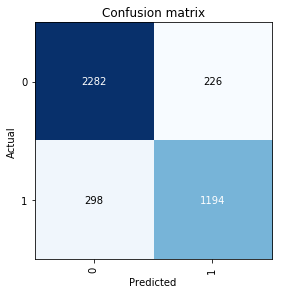

In [68]:
preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True)
interp_t = ClassificationInterpretation(learn, preds_t, y_t, losses_t)
interp_t.plot_confusion_matrix()

In [74]:
to_np((preds_t.argmax(dim=1) == y_t).sum())/len(y_t)

0.869

In [77]:
clas_pred = preds_t.argmax(dim=1)

TP = ((clas_pred==1)*(preds_t.argmax(dim=1) == y_t)).sum()
PRED_POS = (clas_pred==1).sum() #864
prec = TP.item()/PRED_POS.item()
COND_POS = (y_t==1).sum() #864
rec = TP.item()/COND_POS.item()
f'F1-score {2* ((prec*rec)/(prec+rec)):2.5}'

'F1-score 0.82005'

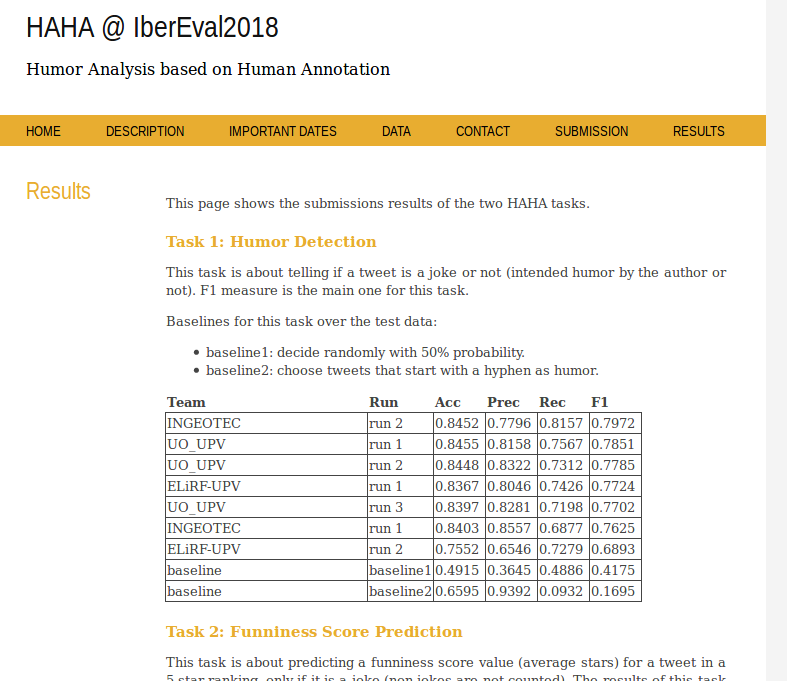